# Bayesian Optimization

In [1]:
import numpy as np
from scipy.stats import entropy

%matplotlib inline
import matplotlib.pyplot as plt

SEED = 12345678
np.random.seed(SEED)

## Regression model

In [2]:
support = np.arange(5)

model = [
    lambda x: np.abs(x - 0),
    lambda x: np.abs(x - 1),
    lambda x: np.abs(x - 2),
    lambda x: np.abs(x - 3),
    lambda x: np.abs(x - 4),
    
    lambda x: np.abs(x - 0) + 1,
    lambda x: np.abs(x - 1) + 1,
    lambda x: np.abs(x - 2) + 1,
    lambda x: np.abs(x - 3) + 1,
    lambda x: np.abs(x - 4) + 1,
    
    lambda x: np.abs(x - 1) + 2,
    lambda x: np.abs(x - 2) + 2,
    lambda x: np.abs(x - 3) + 2,
    
    lambda x: np.abs(x - 2) + 3,
    
    lambda x: (x - 1) ** 2,
    lambda x: (x - 2) ** 2,
    lambda x: (x - 3) ** 2,
    
    lambda x: 9 - (x - 1) ** 2,
    lambda x: 4 - np.abs(x - 3),
    
    lambda x: (x - 2) ** 2 + 1,
]

prior = np.ones(len(model)) / len(model)

In [3]:
def plot_model(xs, fs, posterior, X=None, Y=None):
    X = X if X is not None else []
    Y = Y if Y is not None else []

    alphas = posterior / np.max(posterior)
    
    plt.xticks(support)
    plt.yticks(np.arange(10))
    plt.grid(which='major')
    plt.title('H = %.3lf' % (entropy(posterior), ))
    
    for i, f in enumerate(fs):
        color = plt.cm.tab20(i)
        plt.plot(xs, f(xs), color=color, alpha=alphas[i])
    
    plt.scatter(X, Y, marker='x', color='black')
    plt.xlabel('$x$', fontsize=14)
    plt.ylabel('$f(x)$', fontsize=14)

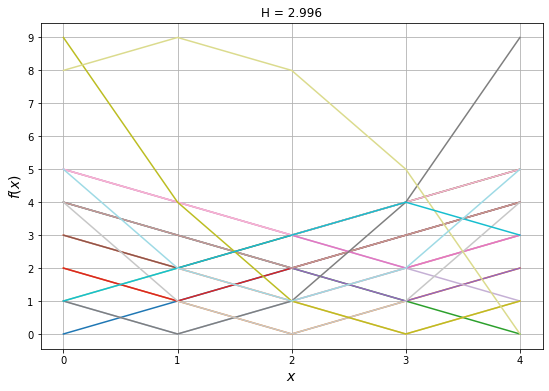

In [4]:
plt.figure(figsize=(9, 6))
plot_model(support, model, prior)

## Data model

In [5]:
def get_observation(target, x):
    y = target(x)
    
    if np.random.binomial(1, 0.5) == 0:
        return y
    else:
        delta = 2 * np.random.randint(2) - 1
        return y + delta

Text(0, 0.5, '$f(x)$')

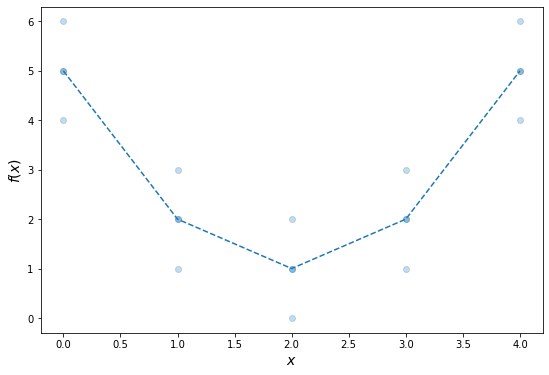

In [6]:
f = model[-1]

plt.figure(figsize=(9, 6))

plt.plot(support, f(support), '--', color=plt.cm.tab10(0))

for dx, p in zip([-1, 0, +1], [0.25, 0.5, 0.25]):
    plt.scatter(support, f(support) + dx, color=plt.cm.tab10(0), alpha=p)

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f(x)$', fontsize=14)

In [7]:
def get_likelihood(f, X, Y):
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    deltas = np.abs(f(X) - Y)

    if np.any(deltas > 1):
        return 0
    else:
        return np.prod(np.where(deltas == 0, 0.5, 0.25))

## Baysian Inference

In [8]:
def get_posterior(fs, X, Y, prior):
    X = np.asarray(X)
    Y = np.asarray(Y)

    posterior = np.zeros_like(prior)
    
    for i, f in enumerate(fs):
        posterior[i] = prior[i] * get_likelihood(f, X, Y)
    
    return posterior / np.sum(posterior)

In this notebook, we work with look-ahead acquisition functions. They select point that minimizes expected criterion:
$$x' = \mathrm{arg\,max}_{x} \big[ \mathbb{E}_{f, y} \mathrm{criterion}(X, Y) - \mathrm{criterion}(X \cup \{x\}, Y \cup \{y\}) \big]$$

*$\mathrm{criterion}(X, Y)$ was added so the acqusition function can be interpreted as a gain of the criterion. For example, when we use an entropy-based criterion than the corresponding look-ahead acqusition function measures information.*

In [9]:
def lookahead_acqusition(criterion):
    def acq(xs, fs, posterior):
        ### the baseline
        H_0 = criterion(xs, fs, posterior)
        
        gains = np.zeros_like(xs, dtype='float')
        
        ### for each x we compute the expected gain if x is probed.
        for i, x in enumerate(xs):
            ### modelling all possible outcomes
            for j, f in enumerate(fs):
                for delta, p_delta in zip([-1, 0, +1], [0.25, 0.5, 0.25]):
                    y = f(x) + delta
                    
                    ### probability of the outcome
                    p_observation = posterior[j] * p_delta
                    
                    ### nearly impossible outomes might
                    ### bring numerical instability
                    if p_observation < 1e-6:
                        continue
                    
                    new_posterior = get_posterior(fs, [x], [y], prior=posterior)
                    H = criterion(xs, fs, new_posterior)
                    gains[i] += (H_0 - H) * p_observation

        return gains

    return acq

In [10]:
def plot_gains(supp, gains):
    plt.bar(supp, gains, color=plt.cm.Set1(2))

    plt.xlabel('x', fontsize=14)
    plt.ylabel('expected gain', fontsize=14)

In [11]:
def select_best(gains):
    max_gain = np.max(gains)
    indx_best, = np.where(gains >= max_gain)
    return np.random.choice(indx_best)

class BayesianOptimization(object):
    def __init__(self, xs, fs, prior, acqusition_f):
        self.xs = xs
        self.fs = fs
        self.prior = prior
        
        self.posterior = prior
        self.acqusition_f = acqusition_f
        
        self.X = list()
        self.Y = list()
    
    def reset(self):
        self.posterior = self.prior
        
        self.X = list()
        self.Y = list()
    
    def tell(self, x, y):
        self.posterior = get_posterior(self.fs, [x], [y], prior=self.posterior)

        self.X.append(x)
        self.Y.append(y)
    
    def ask(self,):
        gains = self.acqusition_f(self.xs, self.fs, self.posterior)
        best_indx = select_best(gains)
        
        return gains, self.xs[best_indx]

## Utilities

In [12]:
def get_min_distribution(xs, fs, posterior):
    """
    Computes distribution of `min f`.
    xs - support of the functions `fs`;
    fs - all possible functions (model);
    posterior - posterior distribution of functions.

    Returns support and distribution of minima.
    """
    distribution = dict()

    for i, f in enumerate(fs):
        min_y = np.min(f(xs))
        distribution[min_y] = distribution.get(min_y, 0.0) + posterior[i]
    
    ys = np.array(list(distribution.keys()))
    min_y, max_y = np.min(ys), np.max(ys)
    
    supp = np.arange(min_y, max_y + 1)
    
    return supp, np.array([distribution.get(y, 0.0) for y in supp])

In [13]:
def plot_min_distribution(supp, distribution):
    plt.barh(supp, distribution, color=plt.cm.Set1(3))
    
    plt.title('H = %.3lf' % (entropy(distribution, )))
    plt.xlabel('probability of min', fontsize=14)
    plt.ylabel('y', fontsize=14)

In [14]:
def get_argmin_distribution(xs, fs, posterior):
    """
    Computes distribution of `argmin f`.
    xs - support of the functions `fs`;
    fs - all possible functions (model);
    posterior - posterior distribution of functions.

    Returns support and distribution of locations of minima.
    """
    distribution = np.zeros_like(xs, dtype='float')

    for i, f in enumerate(fs):
        index_min = np.argmin(f(xs))
        distribution[index_min] += posterior[i]
    
    return xs, distribution

In [15]:
def plot_argmin_distribution(supp, distribution):
    plt.bar(supp, distribution, color=plt.cm.Set1(1))
    
    plt.title('H = %.3lf' % (entropy(distribution, )))
    plt.xlabel('x', fontsize=14)
    plt.ylabel('probability of argmin', fontsize=14)

In [16]:
def plot_info(xs, fs, posterior, X, Y, gains):
    plt.subplots(2, 2, figsize=(9, 9))
    
    plt.subplot(2, 2, 1)
    plot_model(xs, model, posterior, X, Y)
    
    plt.subplot(2, 2, 2)
    supp, distr = get_min_distribution(xs, fs, posterior)
    plot_min_distribution(supp, distr)
    
    plt.subplot(2, 2, 3)
    supp, distr = get_argmin_distribution(xs, fs, posterior)
    plot_argmin_distribution(supp, distr)
    
    plt.subplot(2, 2, 4)
    plot_gains(xs, gains)
    
    plt.tight_layout()
    
    plt.show()

In [17]:
X_test = [2, 3]
Y_test = [2, 1]

posterior_test = get_posterior(model, X_test, Y_test, prior)

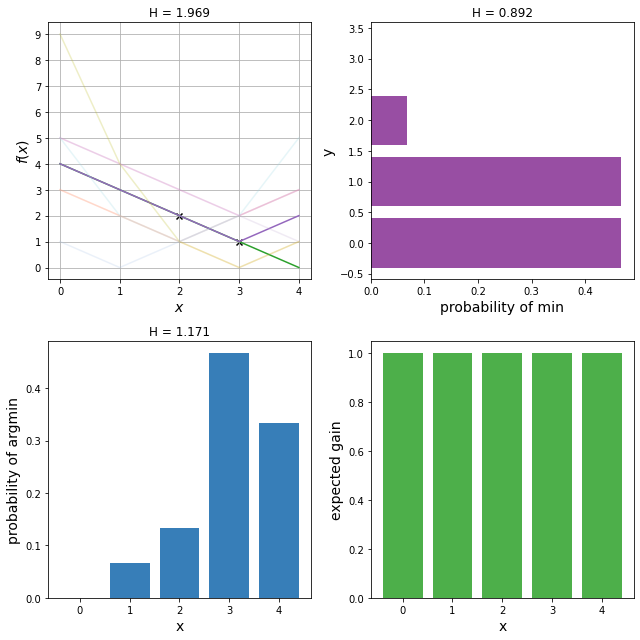

In [18]:
plot_info(support, model, posterior_test, X_test, Y_test, np.ones_like(support))

## Putting all together

In [19]:
def entropy_minimize(ground_truth, support, model, prior, acqusition_f, plot=False):
    bo = BayesianOptimization(support, model, prior=prior, acqusition_f=acqusition_f)
    
    gain = 1

    iteration = 0

    while gain > 1e-3:
        if plot:
            print('iteration %d' % (iteration, ))

        gains, x = bo.ask()
        gain = np.max(gains)
        y = get_observation(ground_truth, x)
        
        if plot:
            plot_info(support, model, bo.posterior, bo.X, bo.Y, gains)
            plt.show()

        bo.tell(x, y)

        iteration += 1
    
    if plot:
        plt.figure(figsize=(6, 6))
        plot_model(support, model, bo.posterior, X=bo.X, Y=bo.Y)
        plt.show()
    
    return bo

## Entropy Model Search

*(It is not a conventional name.)*

In entropy model search , we aim at minimizing entropy of posterior distribution of the model:

$$\mathrm{criterion} = \mathbb{H}\big[ P\big(F \mid X, y\big) \big]$$

Notice, that it is not neccesseraly the most efficient criterion, since it aims to recover the whole objective function, not only position of the minimum. In other words, this acquisition function has no concerns about optimization. *It is purely explorative.*

In [20]:
def entropy_model(xs, fs, posterior):
    return entropy(posterior)

model_search = lookahead_acqusition(entropy_model)

In [21]:
### selecting the ground-truth
model_rng = np.random.RandomState(seed=12345)
model_index = model_rng.randint(len(model), )
ground_truth = model[model_index]

results = entropy_minimize(
    ground_truth,
    support, model, prior,
    acqusition_f=model_search,
    plot=False
)

In [22]:
model_rng = np.random.RandomState(seed=12345)

for _ in range(10):
    ground_truth_model_index = model_rng.randint(len(model), )
    ground_truth = model[ground_truth_model_index]

    results = entropy_minimize(
        ground_truth,
        support, model, prior,
        acqusition_f=model_search,
        plot=False
    )

    inferred = np.argmax(results.posterior)
    assert inferred == ground_truth_model_index

## Entropy Search

*(This time, it is a conventional name.)*

Entropy search is only concerned with the location of the minimum:

$$\mathrm{criterion} = \mathbb{H}\big[ P\big(\mathrm{arg\,min}_{x} F(x) \mid X, y\big) \big]$$


The lookahead acquisition function produced by this criterion is one of the most efficient functions if the goal is to find the position of the minimum without any regards to the rest of objective. Notice, that this function is not concerned with values of the objective function, and does not aim to extact any information about points that are close to the minimum.

In [26]:
def entropy_argmin(xs, fs, posterior):
    _, argmin = get_argmin_distribution(xs, fs, posterior)
    return entropy(argmin)

entropy_search = lookahead_acqusition(entropy_argmin)

In [27]:
### selecting the ground-truth
model_rng = np.random.RandomState(seed=12345)
model_index = model_rng.randint(len(model), )
ground_truth = model[model_index]

results = entropy_minimize(
    ground_truth,
    support, model, prior,
    acqusition_f=entropy_search,
    plot=False
)

In [28]:
model_rng = np.random.RandomState(seed=12345)

for _ in range(10):
    ground_truth_model_index = model_rng.randint(len(model), )
    ground_truth = model[ground_truth_model_index]

    results = entropy_minimize(
        ground_truth,
        support, model, prior,
        acqusition_f=entropy_search,
        plot=False
    )

    inferred = np.argmax(results.posterior)
    ### all functions have a single miminum
    inferred_argmin = np.argmin(model[inferred](support))
    actual_argmin = np.argmin(ground_truth(support))
    
    
    assert inferred_argmin == actual_argmin

## Entropy Value Search

*(Also a conventional name.)*

Entropy value search locates value of the minimum:

$$\mathrm{criterion} = \mathbb{H}\big[ P\big(\mathrm{min}_{x} F(x) \mid X, y\big) \big]$$


The look-ahead acquisition function produced by this criterion does not guarantee that optimization convergences (i.e., locates $\mathrm{argmin}_x f$), however, it might be useful for putting a lower bound on a black-box function.

In [29]:
random_index = np.random.randint(len(model))
ground_truth = model[random_index]

In [30]:
def entropy_min(xs, fs, posterior):
    _, argmin = get_argmin_distribution(xs, fs, posterior)
    return entropy(argmin)

entropy_value_search = lookahead_acqusition(entropy_min)

In [31]:
### selecting the ground-truth
model_rng = np.random.RandomState(seed=12345)
model_index = model_rng.randint(len(model), )
ground_truth = model[model_index]

results = entropy_minimize(
    ground_truth,
    support, model, prior,
    acqusition_f=entropy_value_search,
    plot=False
)

In [32]:
model_rng = np.random.RandomState(seed=12345)

for _ in range(10):
    ground_truth_model_index = model_rng.randint(len(model), )
    ground_truth = model[ground_truth_model_index]

    results = entropy_minimize(
        ground_truth,
        support, model, prior,
        acqusition_f=entropy_value_search,
        plot=False
    )

    inferred = np.argmax(results.posterior)
    inferred_min = np.min(model[inferred](support))
    actual_min = np.min(ground_truth(support))
    
    
    assert np.abs(inferred_min - actual_min) < 1e-3

## Entropy Position-Value Search?

*(It is not a conventional name.)*

Nothing stops us from combining entropy search and entopy value search, by considering joint distribution of minima and their locations:

$$\mathrm{criterion} = \mathbb{H}\big[ P\big((\mathrm{arg\,min}_{x} F(x) \mathrm{min}_{x} F(x), ) \mid X, y\big) \big]$$

In [33]:
def get_min_argmin_distribution(xs, fs, posterior):
    distr = dist()
    
    for i, f in enumerate(fs):
        values = f(xs)
        min_y, min_x = np.min(f(values), xs[np.argmin(values)])
        
        distr[(min_x, min_y)] = distr.get((min_x, min_y), 0.0) + posterior[i]
    return list(distribution.keys()), np.array([distribution.get(y, 0.0) for y in distribution])

def entropy_min_argmin(xs, fs, posterior):
    _, argmin = get_argmin_distribution(xs, fs, posterior)
    return entropy(argmin)

entropy_position_value_search = lookahead_acqusition(entropy_min_argmin)

In [34]:
### selecting the ground-truth
model_rng = np.random.RandomState(seed=12345)
model_index = model_rng.randint(len(model), )
ground_truth = model[model_index]

results = entropy_minimize(
    ground_truth,
    support, model, prior,
    acqusition_f=entropy_position_value_search,
    plot=False
)

In [35]:
model_rng = np.random.RandomState(seed=12345)

for _ in range(10):
    ground_truth_model_index = model_rng.randint(len(model), )
    ground_truth = model[ground_truth_model_index]

    results = entropy_minimize(
        ground_truth,
        support, model, prior,
        acqusition_f=entropy_position_value_search,
        plot=False
    )

    inferred = np.argmax(results.posterior)
    
    inferred_min = np.min(model[inferred](support))
    actual_min = np.min(ground_truth(support))
    
    inferred_argmin = np.argmin(model[inferred](support))
    actual_argmin = np.argmin(ground_truth(support))
    
    
    assert np.abs(inferred_min - actual_min) < 1e-3
    assert inferred_argmin == actual_argmin